In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [240]:
# Parâmetros
u0   = 4*np.pi*1e-9 #.. H/cm
urFe = 2500*u0 #....... H/cm
urAr =    1*u0 #....... H/cm
dx   = 1e0  #............ cm
l    = 22 #.............. cm
h    = 20 #.............. cm
lbd  = 1.75 #     lambda, sobrerrelaxação
tol  = 1e-4 # tolerância, sobrerrelaxação

def gera_grid(dx, l, h):
    '''
    Função que cria, a partir das dimensões do espaço `l` e `h` e a partir da
    discretização deste espaço `dx` (=`dy`) um grid que o descreve
    
    Parameters
    ----------
    dx: float
        passo
    l: float
        largura do grid
    h: float
        altura do grid

    Returns
    -------
    M: int
        tamanho da grade em x
    N: int
        tamanho da grade em y
    X: np.ndarray, dim=(N, M)
        meshgrid em x
    Y: np.ndarray, dim=(N, M)
        meshgrid em y
    grid: np.ndarray, dim=(N, M)
        grid do sistema, inicialmente em branco
    '''
    # dimensões do grid
    M = int(l/dx) + 1
    N = int(h/dx) + 1

    # inicializando o grid
    grid = np.zeros((N, M))

    # criando dois vetores lineares x e y e os usando de base
    # para as matrizes X e Y, resultantes do meshgrid
    x = np.linspace(0, l, M)
    y = np.linspace(-h/2, h/2, N)
    X, Y = np.meshgrid(x, y)


    return M, N, X, Y, grid

def define_elementos(X, Y, grid):
    '''
    Função que toma o `grid`, gerado pelo método `gera_grid()` e o completa
    com a identificação dos elementos que o compõe cada qual em sua posição

    Parameters
    ----------
    X: np.ndarray, dim=(N, M)
        meshgrid em x
    Y: np.ndarray, dim=(N, M)
        meshgrid em y
    grid: np.ndarray, dim=(N, M)
        grid do sistema, inicialmente em branco

    Notes
    -----
    Para tornar o EP mais dinâmico e eficiente, decidiu-se criar apenas um
    grid composto por elementos infinitesimais que indicam o meio ao qual
    pertencem. Para tanto, utilizou-se a seguinte notação:
    - 0: pontos que não fazem parte do grid (resto que fica acima e abaixo
         da parte à direita da bobina, para preencher o espaço retangular)
    - 1: entreferro
    - 2: armadura
    - 3: núcleo de ferro
    - 4: bobina_LE
    - 5: bobina_LD
    Com este método, todas as grandezas que dependem do meio podem facilmente
    ser definidas e, apenas com uma matriz, é possível descrever por exemplo
    a corrente Jz em todo o sistema (podemos filtrar os pontos em que temos
    a bobina e tornar todo o resto da matriz 0)
    '''
    # definindo as regiões dos diferentes elementos
    armadura = (X <= 4)
    entreferro = np.logical_or(
        # primeiro retângulo, 
        # -10 <  y <  10
        #   4 <  X <   5
        np.logical_and(X > 4, X < 5),
        # região do meio,
        #  -6 <  y <   6
        #   5 <= x <  14
        np.logical_and(
            np.logical_and(X >= 5, X < 14),
            np.logical_and(Y > -6, Y < 6)
            )
        )

    nucleo = np.logical_or(
        # pontas
        # y <= -6 | y >= 6
        # 5 <= x <  20
        np.logical_and(
            np.logical_and(X >= 5, X <= 20),
            np.logical_or(Y <= -6, Y >= 6)
            ),
        # barra vertical (entre as bobinas)
        # -10 <  y <  10
        #  16 <  x <  16
        np.logical_and(X > 16, X < 20)
        )

    bobina_LE =  np.logical_and(
        # bobina da esquerda (corrente entrando na folha)
        #  -6 <= y <=  6
        #  14 <= x <  16
        np.logical_and(X >= 14, X <= 16),
        np.logical_and(Y >= -6, Y <=  6)
        )
    
    bobina_LD = np.logical_and(
        # bobina da direita (corrente saindo da folha)
        #  -6 <= y <=  6
        #  20 <= x <  22
        np.logical_and(X >= 20, X <= 22),
        np.logical_and(Y >= -6, Y <=  6)
        )
        

    # assignando os códigos de cada região (regiões não assignadas não fazem
    # parte do sistema, região externa, continuam em 0)
    grid[entreferro]    = 1
    grid[armadura]      = 2
    grid[nucleo]        = 3
    grid[bobina_LE]     = 4
    grid[bobina_LD]     = 5
    
    return grid

def gera_mu(grid, urAr, urFe):
    '''
    Método que gera uma matriz com o valor das permeabilidades
    para cada elemento do grid

    Parameters
    ----------
    grid: np.ndarray, dim=(N, M)
        grid do sistema, contém as identificações dos elementos
    urAr: float
        permeabilidade magnética do ar
    urFe: float
        permeabilidade magnética do ferro

    Returns
    -------
    mu: np.ndarray, dim=(N, M)
        valores da permeabilidade (mu) em cada meio
    '''
    mu = np.piecewise(grid, 
        [
        grid==0,  #vazios      - mu_Ar
        grid==1,  #entreferro  - mu_Ar
        grid==2,  #armadura    - mu_Fe
        grid==3,  #nucleoFerro - mu_Fe
        grid==4,  #bobinaLE    - mu_Ar
        grid==5   #bobinaLD    - mu_Ar
        ], 
        [urAr, urAr, urFe, urFe, urAr, urAr]
    )
    return mu

def gera_mu_redondezas(mu, M, N):
    '''
    Função que gera uma array 3-D (NxMx4) com os mus adjacentes
    a cada ponto (i, j)
    
    Parameters
    ----------
    mu: np.ndarray, dim=(N, M)
        valores da permeabilidade (mu) em cada meio
    M: int
        tamanho da grade em x
    N: int
        tamanho da grade em y

    Returns
    -------
    mu_redondezas: np.ndarray, dim=(N, M, 4)

    Notes
    -----
    A ordem adotada para os mus nos índices da matriz é: cima, esquerda,
    direita, baixo
    '''
    mu_redondezas = np.zeros((N, M, 4))
    mu_redondezas[:, :, 0] = np.roll(mu,  shift=1, axis=0) # cima
    mu_redondezas[:, :, 1] = np.roll(mu,  shift=1, axis=1) # esquerda
    mu_redondezas[:, :, 2] = np.roll(mu, shift=-1, axis=1) # direita
    mu_redondezas[:, :, 3] = np.roll(mu, shift=-1, axis=0) # baixo

    return mu_redondezas

def inicializa_matriz_A(dx, l, h):
    '''
    Função que inicializa a matriz A, dos potenciais eletromagnéticos
    
    Parameters
    ----------
    dx: float
        passo
    l: float
        largura do grid
    h: float
        altura do grid
    '''
    _, _, _, _, A = gera_grid(dx, l, h)
    
    return A

def aplica_cc(A, grid):
    '''
    Função que aplica as condições de contorno em A, o que inclui
    as condições de Dirichlet (potencial na fronteira externa constante
    e igual a 0) e também zera o potencial para os pontos do grid que
    "não pertencem" ao problema (pontos que foram anexados para tornar)
    o grid regular, mas que não fazem parte do problema
    '''
    # bordas com potencial nulo
    A[ 0,  :] = 0
    A[-1,  :] = 0
    A[ :,  0] = 0
    A[ :, -1] = 0
    # zera partes que não pertencem ao problema
    A         = np.where(grid==0, 0, A)
    
    return A

def gera_matriz_uJ(mu, X, Y, grid):
    '''
    Função que gera a matriz de correntes, J, que é nula em todo
    o espaço, exceto dentro da bobina
    
    Parameters
    ----------
    mu: np.ndarray, dim=(N, M)
        valores da permeabilidade (mu) em cada meio
    X: np.ndarray, dim=(N, M)
        meshgrid em x
    Y: np.ndarray, dim=(N, M)
        meshgrid em y
    grid: np.ndarray, dim=(N, M)
        grid do sistema, inicialmente em branco
        
    Returns
    -------
    uJ: np.ndarray, dim=(N, M)
    '''
    def calcula_J(y):
        '''
        Função auxiliar que calcula a corrente dado um ponto y
        '''
        return 2e6*np.cos(np.pi*y/12) + 8e5
    
    J  = np.where(grid==4, -calcula_J(Y), 0) + np.where(grid==5, calcula_J(Y), 0)
    uJ = - np.multiply(J, mu)
    
    return uJ

def calcula_A(A, dx, M, N, grid, uJ, mu):
    '''
    Função que calcula o potencial eletromagnético para
    todos os pontos do grid
    '''
    Anew = A.copy()
    # para cada linha
    for j in range(1, N-1):
        # para cada coluna
        for i in range(1, M-1):
            uC = mu[j + 1,     i]
            uB = mu[j - 1,     i]
            uE = mu[    j, i - 1]
            uD = mu[    j, i + 1]
            
            
            Anew[j, i] = 1/2 * (A[j+1, i]*(1 - (uC/(uC + uB))) + A[j-1, i]*(uC/(uC + uB)) 
                           + A[j, i+1]*(1 - (uD/(uD + uE))) + A[j, i-1]*(uD/(uD + uE))
                           + dx**2/2 * uJ[j, i])
    return Anew
            
def sobrerrelaxa(dx, l, h, urAr, urFe, lbd, tol):
    '''
    Função que aplica a sobrerrelaxação usando com um determinado passo
    usando um determinado lambda até uma determinada tolerância
    
    Parameters
    ----------
    dx: float
        passo
    l: float
        largura do grid
    h: float
        altura do grid
    urAr: float
        permeabilidade magnética do ar
    urFe: float
        permeabilidade magnética do ferro
    lbd: float
        lambda da sobrerrelaxação
    tol: float
        tolerância de erro da sobrerrelaxação
    '''
    M, N, X, Y, grid = gera_grid(dx, l, h)
    A    = inicializa_matriz_A(dx, l, h)
    grid = define_elementos(X, Y, grid)
    mu   = gera_mu(grid, urAr, urFe)
    uJ   = gera_matriz_uJ(mu, X, Y, grid)
    Anew = calcula_A(A, dx, M, N, grid, uJ, mu)
    erro = np.max(np.abs(Anew - A))
    i = 0
    while erro > tol and i < 2000:
        Anew, A = lbd*calcula_A(Anew, dx, M, N, grid, uJ, mu) + (1 - lbd)*A, Anew
        aplica_cc(A, grid)
        erro    = np.max(np.abs(np.divide(Anew - A, Anew, out=np.zeros_like(Anew), where=Anew!=0)))
        i+= 1
    print(i, erro)
    return Anew

In [176]:
i = 0; b = 0

In [191]:
M, N, X, Y, grid = gera_grid(dx, l, h)
A    = inicializa_matriz_A(dx, l, h)
grid = define_elementos(X, Y, grid)
mu   = gera_mu(grid, urAr, urFe)
uJ   = gera_matriz_uJ(mu, X, Y, grid)
Anew = calcula_A(A, dx, M, N, grid, uJ, mu)
erro = np.max(np.abs(Anew - A))
i = 0
#while erro > tol:
#    if i%1==0: print(f"{i=}, {erro=:.3f}"); i+=1;
#    Anew, A = lbd*calcula_A(Anew, dx, M, N, grid, uJ, mu) + (1 - lbd)*A, Anew
#    erro    = np.max(np.abs(Anew - A))
#    aplica_cc(A, grid)

2000 0.0017961343297647576


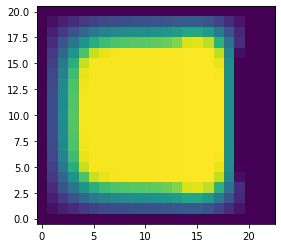

In [241]:
plt.imshow(sobrerrelaxa(dx, l, h, urAr, urFe, lbd, tol), origin='lower', interpolation="none")

In [85]:
urFe = 2500*u0 #........ H/m
urAr =    1*u0 #........ H/m
mu = gera_mu(grid, urAr, urFe)

In [57]:
M, N, X, Y, grid = gera_grid(dx, l, h)
_, _, _, _, A    = gera_grid(dx, l, h)

In [79]:
def calcula_J(y):
    '''
    Função auxiliar que calcula a corrente dado um ponto y
    '''
    return 2e6*np.cos(np.pi*y/1.2e-1) + 8e5

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

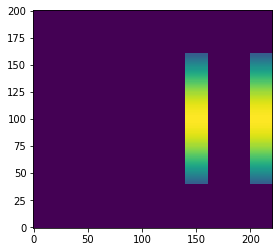

In [81]:
plt.imshow(np.where(grid==4, calcula_J(Y), 0), origin='lower', interpolation="none")

In [58]:
grid = define_elementos(X, Y, grid)

In [41]:
np.piecewise(grid, [grid!=0, grid==0], [0, 1])

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [33]:
np.piecewise(grid, [grid!=2, grid==2], [0, 1])

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

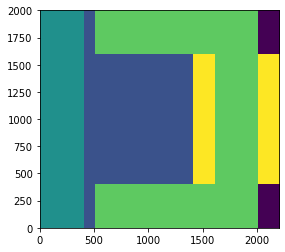

In [34]:
plt.imshow(grid, origin='lower', interpolation="none")

In [16]:
a = np.roll(mu(), -1, 1)
a[:, -1]
a

array([[3.14159265e-03, 3.14159265e-03, 3.14159265e-03, ...,
        1.25663706e-06, 1.25663706e-06, 3.14159265e-03],
       [3.14159265e-03, 3.14159265e-03, 3.14159265e-03, ...,
        1.25663706e-06, 1.25663706e-06, 3.14159265e-03],
       [3.14159265e-03, 3.14159265e-03, 3.14159265e-03, ...,
        1.25663706e-06, 1.25663706e-06, 3.14159265e-03],
       ...,
       [3.14159265e-03, 3.14159265e-03, 3.14159265e-03, ...,
        1.25663706e-06, 1.25663706e-06, 3.14159265e-03],
       [3.14159265e-03, 3.14159265e-03, 3.14159265e-03, ...,
        1.25663706e-06, 1.25663706e-06, 3.14159265e-03],
       [3.14159265e-03, 3.14159265e-03, 3.14159265e-03, ...,
        1.25663706e-06, 1.25663706e-06, 3.14159265e-03]])

In [3]:
# Parâmetros
u0   = 4*np.pi*1e-7 #... H/m
urf  = 2500*u0 #........ H/m
urAr =    1*u0 #........ H/m
prof =    8e-2 #.......... m
dx   = 1e-2


def gera_grid(dx, l=22, h=20):
    '''
    Função que cria, a partir das dimensões do espaço `l` e `h` e a partir da
    discretização deste espaço `dx` (=`dy`) um grid que o descreve
    
    Parameters
    -----------
    dx: float
        discretização da malha quadrada
    l: float (default=22)
        largura do sistema
    h: float (default=20)
        altura do sistema
        
    Returns
    -------
    grid: np.ndarray, dim=(N, M)
        grid do sistema, com os devidos elementos localizados através dos 
        códigos apresentados nas notas da função; note que M=int(l/dx) e
        N=int(h/dx)
    
    Notes
    -----
    Para tornar o EP mais dinâmico e eficiente, decidiu-se criar apenas um
    grid composto por elementos infinitesimais que indicam o meio ao qual
    pertencem. Para tanto, utilizou-se a seguinte notação:
    - 0: pontos que não fazem parte do grid (resto que fica acima e abaixo
         da parte à direita da bobina, para preencher o espaço retangular)
    - 1: entreferro
    - 2: armadura
    - 3: núcleo de ferro
    - 4: bobina
    Com este método, todas as grandezas que dependem do meio podem facilmente
    ser definidas e, apenas com uma matriz, é possível descrever por exemplo
    a corrente Jz em todo o sistema (podemos filtrar os pontos em que temos
    a bobina e tornar todo o resto da matriz 0)
    '''
    # dimensões do grid
    M = int(l/dx) + 1
    N = int(h/dx) + 1
    
    # inicializando o grid
    grid = np.zeros((N, M))

    # criando dois vetores lineares x e y e os usando de base
    # para as matrizes X e Y, resultantes do meshgrid
    x = np.linspace(0, l, M)
    y = np.linspace(-h/2, h/2, N)
    X, Y = np.meshgrid(x, y)
    
    # definindo as regiões dos diferentes elementos
    armadura = (X <= 4)
    entreferro = np.logical_or(
        # primeiro retângulo, 
        # -10 <  y <  10
        #   4 <  X <   5
        np.logical_and(X > 4, X < 5),
        # região do meio,
        #  -6 <  y <   6
        #   5 <= x <  14
        np.logical_and(
            np.logical_and(X >= 5, X < 14),
            np.logical_and(Y > -6, Y < 6)
            )
        )

    nucleo = np.logical_or(
        # pontas
        # y <= -6 | y >= 6
        # 5 <= x <  20
        np.logical_and(
            np.logical_and(X >= 5, X <= 20),
            np.logical_or(Y <= -6, Y >= 6)
            ),
        # barra vertical (entre as bobinas)
        # -10 <  y <  10
        #  16 <  x <  16
        np.logical_and(X > 16, X < 20)
        )
    
    bobina = np.logical_or(
        # bobina da esquerda (corrente entrando na folha)
        #  -6 <= y <=  6
        #  14 <= x <  16
        np.logical_and(
            np.logical_and(X >= 14, X <= 16),
            np.logical_and(Y >= -6, Y <=  6)
            ),
        #  -6 <= y <=  6
        #  20 <= x <  22
        np.logical_and(
            np.logical_and(X >= 20, X <= 22),
            np.logical_and(Y >= -6, Y <=  6)
            )
        )
    
    # assignando os códigos de cada região (regiões não assignadas não fazem
    # parte do sistema, região externa, continuam em 0)
    grid[entreferro] = 1
    grid[armadura]   = 2
    grid[nucleo]     = 3
    grid[bobina]     = 4
    
    return grid


def discretiza_elementos(dx, l=22, h=20):
    '''
    Função que gera um grid a partir das informações da malha e de suas dimensões
    e localiza os diferentes elementes, assignando a eles diferentes códigos
    '''


def Jz():
    '''
    Função que retorna a corrente elétrica distribuida na bobina na direção
    z (saindo da folha)
    
    Returns
    -------
    Jz: np.ndarray, dim=(N, M)
        corrente elétrica distribuida na direção do eixo z
    '''
    grid = gera_grid(dx)
    N = grid.shape[0]
    M = grid.shape[1]
    
    Jz = np.zeros((N, M))
    
    
    
            #Jz = 2e6*np.cos(np.pi*y/1.2e-1) + 8e5

    
    return Jz

def mu(urf=urf, urAr=urAr, dx=dx):
    '''
    Função que retorna uma grid com os valores de mu para cada material
    
    Parameters
    -----------
    urf:  float (default=urf)
        permeabilidade do núcleo de ferro e da armadura
    urAr: float (default=urAr)
        permeabilidade do ar e da bobina
    dx: float
        discretização da malha quadrada
    
    Returns
    -------
    mu: np.ndarray, dim=(N, M)
        valores de mu em cada meio
    '''
    grid_mus = gera_grid(dx)
    grid_mus = np.piecewise(grid_mus, [
        grid_mus==0,  #vazios      - mu_Ar
        grid_mus==1,  #entreferro  - mu_Ar
        grid_mus==2,  #armadura    - mu_Fer
        grid_mus==3,  #nucleoFerro - mu_Fer
        grid_mus==4], #bobina      - mu_Ar
        [urAr, urAr, urf, urf, urAr]
    )
    return grid_mus

In [8]:
a  = np.asarray([[1, 2], [2, 3]])
np.piecewise(a, [a!= 1, a==1], [0, 1])

array([[1, 0],
       [0, 0]])

In [35]:
grid

array([[2., 2., 2., ..., 0., 0., 0.],
       [2., 2., 2., ..., 0., 0., 0.],
       [2., 2., 2., ..., 0., 0., 0.],
       ...,
       [2., 2., 2., ..., 0., 0., 0.],
       [2., 2., 2., ..., 0., 0., 0.],
       [2., 2., 2., ..., 0., 0., 0.]])

In [24]:
import scipy

In [28]:
np.roll??

Signature: np.roll(a, shift, axis=None)
Source:   
@array_function_dispatch(_roll_dispatcher)
def roll(a, shift, axis=None):
    """
    Roll array elements along a given axis.

    Elements that roll beyond the last position are re-introduced at
    the first.

    Parameters
    ----------
    a : array_like
        Input array.
    shift : int or tuple of ints
        The number of places by which elements are shifted.  If a tuple,
        then `axis` must be a tuple of the same size, and each of the
        given axes is shifted by the corresponding number.  If an int
        while `axis` is a tuple of ints, then the same value is used for
        all given axes.
    axis : int or tuple of ints, optional
        Axis or axes along which elements are shifted.  By default, the
        array is flattened before shifting, after which the original
        shape is restored.

    Returns
    -------
    res : ndarray
        Output array, with the same shape as `a`.

    See Also
    ---